# Loading Dataset from Minio

In [8]:

import pandas as pd
import mlflow
import mlflow.sklearn
from src.data_processing import download_data_from_minio, load_and_preprocess_data
from src.model_training import tune_prophet_hyperparameters, train_final_model
from src.utils import log_results_to_mlflow

if data versioning is applied, use the code below:
<code>
version_id = 'your-version-id-here'
s3_client.download_file(bucket_name, object_name, '/home/jovyan/work/nvidia_stock_prices.csv', ExtraArgs={"VersionId": version_id})</code>


In [9]:
bucket_name = 'stocks'
object_name = 'nvidia_stock_prices.csv'
file_path = '/home/jovyan/work/nvidia_stock_prices.csv'

download_data_from_minio(bucket_name, object_name, file_path)

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)
print(data.head(10))

         Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000
5  2004-01-09  0.207833  0.214833  0.206167  0.212250   766584000
6  2004-01-12  0.213000  0.215333  0.211000  0.214667   541980000
7  2004-01-13  0.213583  0.215667  0.201333  0.203583   865800000
8  2004-01-14  0.204583  0.207500  0.200167  0.202083   544872000
9  2004-01-15  0.200583  0.204083  0.197000  0.202417   609204000


# Data Preprocessing

In this experiment we only use one feature which is the "Close"
- (**Suggestions**) we could add more features such as Volume and Open to increase the accuracy of the prediction

In [10]:
data = load_and_preprocess_data(file_path)

data.head(5)

,ds,y
0,2004-01-02,0.192333
1,2004-01-05,0.198583
2,2004-01-06,0.206667
3,2004-01-07,0.208500
4,2004-01-08,0.209250


# MLflow Experiment

In this experiment we use GridSearch for autotuning the hyperparameter and use MSE (Mean Squared Error) for performance metric. The result of the experiment will be saved in bucket "mlflow" in minio that will contains 2 plots (main and component plots).
- (**Suggestions**) To evaluate the performance of the model further, we could apply other metrics such as R-Squared and MAE (Mean Absolute Error) 

In [11]:
# Define hyperparameter grid
params_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0]
}

In [12]:
# It tells Jupyter notebook to connect to the MLflow server using the Docker Compose service name
mlflow.set_tracking_uri('http://mlflow-web:5000')

# Set up the experiment name in the MLflow
experiment_name = "experiment_nvidia_prophet"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='s3://mlflow/1', creation_time=1735011547908, experiment_id='1', last_update_time=1735011547908, lifecycle_stage='active', name='experiment_nvidia_prophet', tags={}>

In [13]:
# Find the best hyperparameters and best MSE
best_hyperparams, best_mse = tune_prophet_hyperparameters(data, params_grid)

05:40:37 - cmdstanpy - INFO - Chain [1] start processing
05:40:38 - cmdstanpy - INFO - Chain [1] done processing
05:40:39 - cmdstanpy - INFO - Chain [1] start processing
05:40:40 - cmdstanpy - INFO - Chain [1] done processing
05:40:41 - cmdstanpy - INFO - Chain [1] start processing
05:40:41 - cmdstanpy - INFO - Chain [1] done processing
05:40:42 - cmdstanpy - INFO - Chain [1] start processing
05:40:43 - cmdstanpy - INFO - Chain [1] done processing
05:40:44 - cmdstanpy - INFO - Chain [1] start processing
05:40:44 - cmdstanpy - INFO - Chain [1] done processing
05:40:46 - cmdstanpy - INFO - Chain [1] start processing
05:40:46 - cmdstanpy - INFO - Chain [1] done processing
05:40:47 - cmdstanpy - INFO - Chain [1] start processing
05:40:48 - cmdstanpy - INFO - Chain [1] done processing
05:40:49 - cmdstanpy - INFO - Chain [1] start processing
05:40:50 - cmdstanpy - INFO - Chain [1] done processing
05:40:52 - cmdstanpy - INFO - Chain [1] start processing
05:40:52 - cmdstanpy - INFO - Chain [1]

05:41:06 - cmdstanpy - INFO - Chain [1] start processing
05:41:07 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run crawling-dolphin-863 at: http://mlflow-web:5000/#/experiments/1/runs/adf1eab7c5c9431da5465a4dbe1cd0e3
🧪 View experiment at: http://mlflow-web:5000/#/experiments/1


S3UploadFailedError: Failed to upload predict/forecast_plot.png to mlflow/1/adf1eab7c5c9431da5465a4dbe1cd0e3/artifacts/forecast_plot.png: An error occurred (NoSuchBucket) when calling the PutObject operation: The specified bucket does not exist

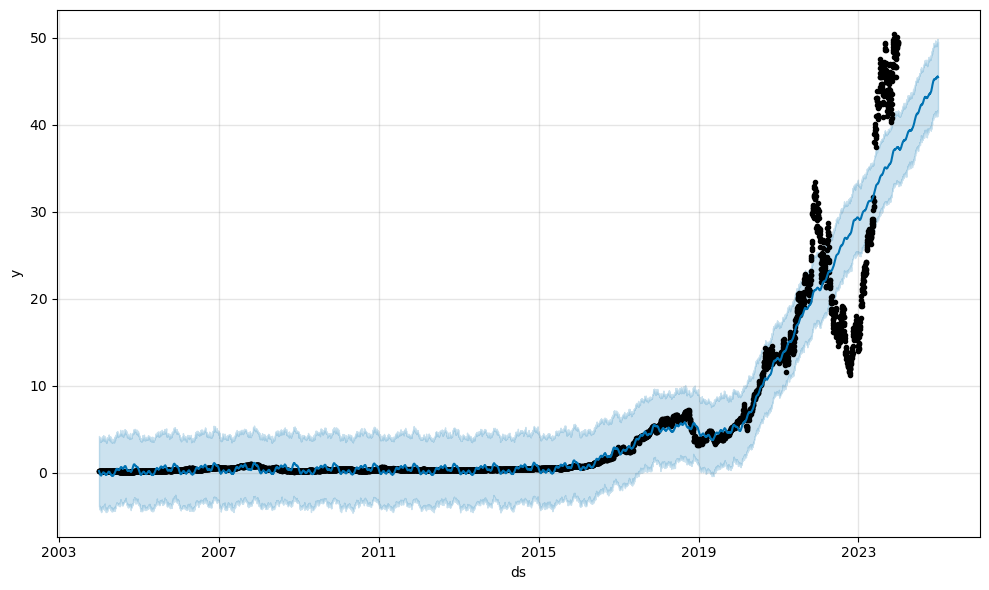

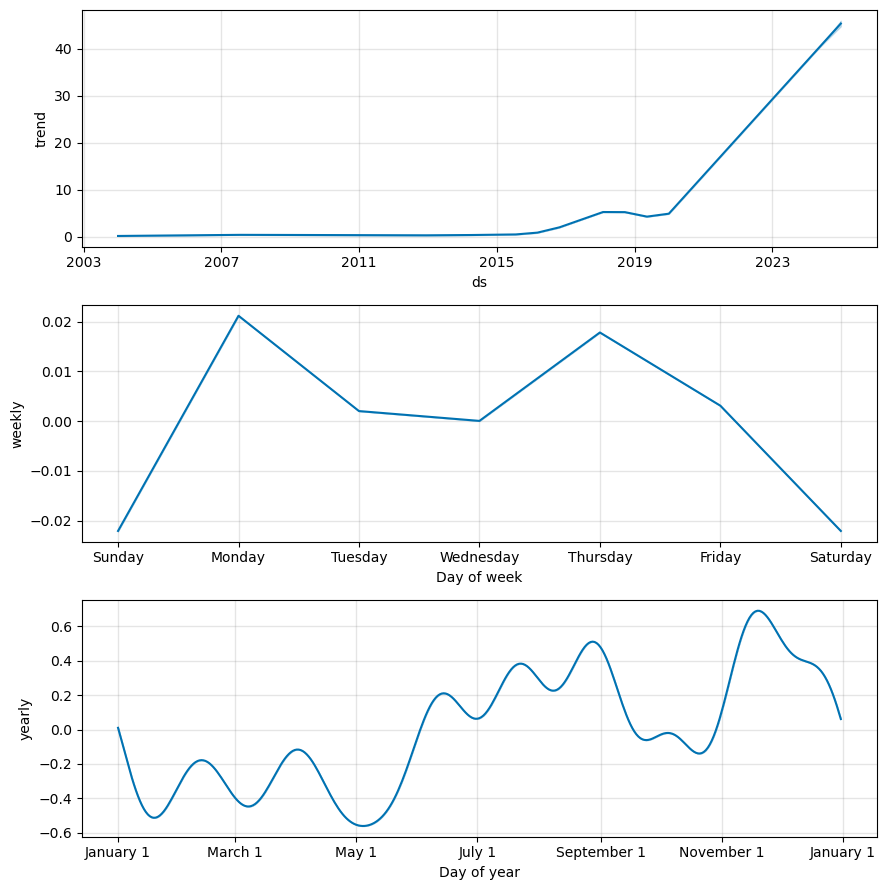

In [14]:
# Start an MLflow run
with mlflow.start_run():

    # Train the final model with the best hyperparameters
    final_model = train_final_model(data, best_hyperparams)

    # Make future predictions
    future = final_model.make_future_dataframe(periods=365)
    forecast = final_model.predict(future)

    # Save the main plot
    fig1 = final_model.plot(forecast)

    # Save the components plot
    fig2 = final_model.plot_components(forecast)

    # Log the best hyperparameters, best MSE, and plots to MLflow
    log_results_to_mlflow(best_hyperparams, best_mse, mlflow)

In [15]:
# Print the best hyperparameters and best MSE
print("Best Hyperparameters:", best_hyperparams)
print("Best MSE:", best_mse)

Best Hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}
Best MSE: 9.731330092520974
